<a href="https://colab.research.google.com/github/markyleangela/CNN-Projects/blob/main/CNN_Transfer_Learning_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://huggingface.co/datasets/navhci/cat-breed-class

Cloning into 'cat-breed-class'...
remote: Enumerating objects: 1867, done.
remote: Total 1867 (delta 0), reused 0 (delta 0), pack-reused 1867 (from 1)
Receiving objects: 100% (1867/1867), 268.71 KiB | 14.93 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Filtering content: 100% (1827/1827), 51.78 MiB | 1.88 MiB/s, done.


In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.models import Model
from keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import pandas as pd
import requests
import os
from tqdm import tqdm
import torch
from PIL import Image
from sklearn.model_selection import train_test_split

In [13]:
import os
labels = os.listdir("cat-breed-class")  # Replace with your dataset name
print(labels)

['.gitattributes', 'training', 'validation', '.git']


In [19]:
import math
# Load Training Data
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "cat-breed-class/training",  # Correct path
    image_size=(224, 224),
    batch_size=32
)

# Load Validation Data
val_dataset = tf.keras.utils.image_dataset_from_directory(
    "cat-breed-class/validation",  # Correct path
    image_size=(224, 224),
    batch_size=32
)

# Get the number of batches in validation dataset
val_batches = len(val_dataset)  # Number of batches
test_batches = math.ceil(0.2 * val_batches)  # 20% of validation

# Split dataset
test_dataset = val_dataset.take(test_batches)  # Take first 20% for testing
val_dataset = val_dataset.skip(test_batches)  # Remaining 80% for validation

Found 1227 files belonging to 4 classes.
Found 600 files belonging to 4 classes.


In [26]:
print(len(train_dataset)) #1227 / 32 (batch_size) = 39
print(len(val_dataset))
print(len(test_dataset))


39
15
4


In [22]:
class_names = train_dataset.class_names
print("Unique Classes:", class_names)

Unique Classes: ['abyssian', 'munchkin', 'persian', 'toyger']


In [23]:
class_names_dict = {
    'abyssian': 0,
    'munchkin': 1,
    'persian': 2,
    'toyger': 3,

}

In [27]:
def preprocess(image, label):
    final_image = tf.keras.applications.resnet.preprocess_input(image)  # Normalize
    return final_image, label


In [28]:
train_dataset = train_dataset.shuffle(100)
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [29]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,  # Removes the fully connected layer (we add our own)
    weights="imagenet",  # Pretrained on ImageNet
    input_shape=(224, 224, 3),  # Input image size
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [30]:
model = base_model.output
model = GlobalAveragePooling2D()(model)  # Converts feature maps to a single vector
model = Dense(128, activation="relu")(model)  # Fully connected layer
output_layer = Dense(4, activation="softmax")(model)  # Final 4 classes [#26.4% Persian #25.7% Abyssian #24.2% Toyger #23.7% munchkin]
model = Model(inputs=base_model.input, outputs=output_layer)

In [31]:
for layer in base_model.layers:
  layer.trainable = False

In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    verbose=1)


Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 33s 453ms/step - accuracy: 0.6380 - loss: 0.9576 - val_accuracy: 0.9195 - val_loss: 0.2229
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9235 - loss: 0.2002 - val_accuracy: 0.9258 - val_loss: 0.2262
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.9584 - loss: 0.1404 - val_accuracy: 0.9280 - val_loss: 0.2085
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9684 - loss: 0.0978 - val_accuracy: 0.9301 - val_loss: 0.2101
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9820 - loss: 0.0601 - val_accuracy: 0.9068 - val_loss: 0.2412


In [36]:
# Get a batch of images and labels
image_batch, label_batch = next(iter(test_dataset.take(1)))  # Take one batch
predictions = model.predict(image_batch)  # Get predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


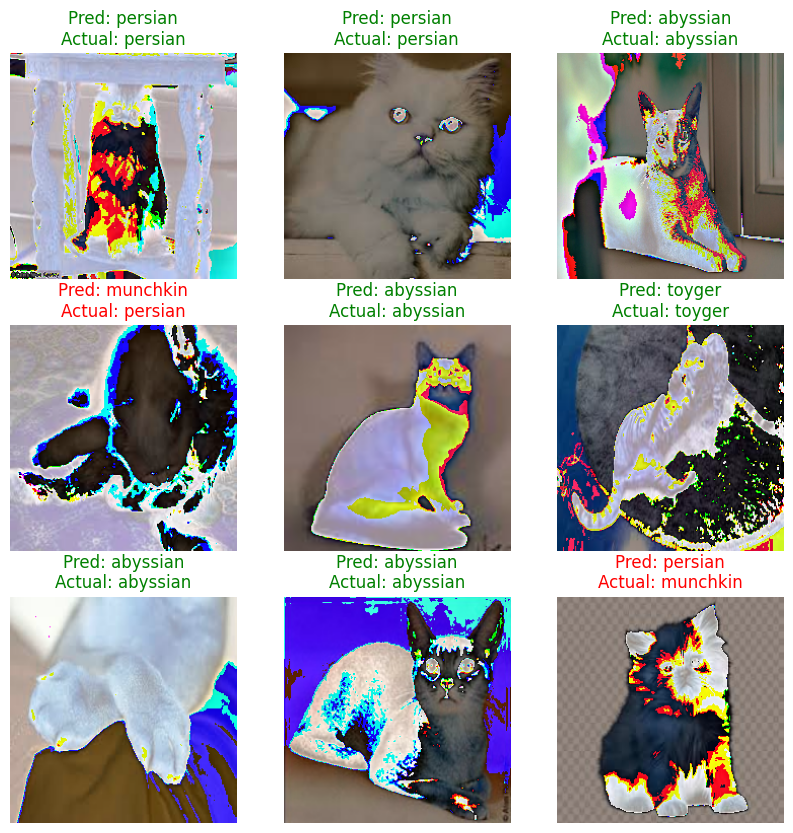

In [37]:
import matplotlib.pyplot as plt
import numpy as np



# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Plot the images with predictions
plt.figure(figsize=(10, 10))
for i in range(9):  # Show first 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))  # Convert tensor to image
    plt.axis("off")

    actual_label = class_names[label_batch[i].numpy()]
    predicted_label = class_names[predicted_labels[i]]

    # Display prediction result
    color = "green" if actual_label == predicted_label else "red"
    plt.title(f"Pred: {predicted_label}\nActual: {actual_label}", color=color)

plt.show()
